In [1]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import yfinance as yf

warnings.filterwarnings("ignore")

ff15_model = pdr.get_data_famafrench(
    'F-F_Research_Data_5_Factors_2x3_daily',
    start='2004-02-02'
)
c97_model = pdr.get_data_famafrench(
    'F-F_Momentum_Factor_daily',
    start='2004-02-02'
)
data = pd.concat(
    [ff15_model[0], c97_model[0]],
    axis=1
)

price = yf.download(
    'XOM',
    #'XLE',
    start='2004-01-30',
    end='2024-09-01',
    progress=False
)

In [2]:
ret = price['Adj Close'].pct_change().dropna()
ret.name = 'return'
data = data * 0.01
excess_return = ret - data['RF']
excess_return.name = 'excess_return'
data.drop(['RF'], axis=1, inplace=True)
data.columns = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM']

In [3]:
oil_factor = pd.read_parquet('../Data/oil_factor.parquet')

In [4]:
oil_factor[oil_factor > 1] = oil_factor[oil_factor > 1] * 0.01
oil_factor[oil_factor > 0.5] = oil_factor[oil_factor > 0.5] * 0.1
oil_factor[oil_factor < -0.3] = oil_factor[oil_factor < -0.3] * 0.1

In [5]:
data = pd.concat(
    [data, oil_factor.loc['2004-01-30':]],
    axis = 1
)

In [6]:
data.columns = ['Mkt-RF','SMB','HML','RMW','CMA','MOM','OIL']

In [7]:
data = data.loc['2004-02':'2024-08']

In [8]:
excess_return = excess_return.loc['2004-02':'2024-08']

### Modeling

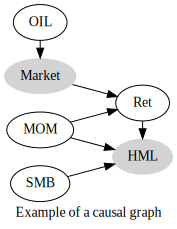

In [27]:
import graphviz as gr

chain = gr.Digraph(
    'G',
    node_attr = {'shape': 'ellipse'}, 
    graph_attr = {
        'rankdir': 'LR',
        'label': 'Example of a causal graph'
    }
)

chain.edge('Market', 'Ret')
chain.edge('MOM', 'Ret')
chain.edge('MOM', 'HML')
chain.edge('SMB', 'HML')
chain.edge('Ret', 'HML')
chain.edge('OIL', 'Market')

chain.node(
    'HML', style = 'filled', 
    fillcolor = 'lightgray', 
    shape = 'ellipse', 
    penwidth = '0'
)
chain.node(
    'Market', style = 'filled', 
    fillcolor = 'lightgray', 
    shape = 'ellipse', 
    penwidth = '0'
)

with chain.subgraph() as s:
    s.attr(rank = 'same') 
    s.node('Ret')
    s.node('HML')
with chain.subgraph() as s:
    s.attr(rank = 'same') 
    s.node('Market')
    s.node('OIL')
    s.node('MOM')

chain

In [28]:
import statsmodels.api as sm

X = sm.add_constant(
    data
)
ols2 = sm.OLS(excess_return, X).fit()
print(ols2.summary())

                            OLS Regression Results                            
Dep. Variable:          excess_return   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     750.8
Date:                Fri, 01 Nov 2024   Prob (F-statistic):               0.00
Time:                        00:23:48   Log-Likelihood:                 15710.
No. Observations:                5181   AIC:                        -3.140e+04
Df Residuals:                    5173   BIC:                        -3.135e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -9.15e-05      0.000     -0.500      0.6

In [29]:
X = sm.add_constant(
    data['OIL']
)
treatment = sm.OLS(data['Mkt-RF'], X).fit()
print(treatment.summary())

                            OLS Regression Results                            
Dep. Variable:                 Mkt-RF   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.027
Date:                Fri, 01 Nov 2024   Prob (F-statistic):             0.0448
Time:                        00:24:02   Log-Likelihood:                 15524.
No. Observations:                5181   AIC:                        -3.104e+04
Df Residuals:                    5179   BIC:                        -3.103e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      3.052      0.0

In [30]:
mkt_hat = treatment.resid
mkt_hat.name = 'Mkt_hat'

### HML Factor

In [31]:
T = sm.add_constant(
    data[['MOM', 'SMB']]
)
y_t = data['HML']
ols0 = sm.OLS(y_t, T).fit()
print(ols0.summary())  # true positive based causal graph
hml_hat = ols0.resid
hml_hat.name = 'HML_hat'

                            OLS Regression Results                            
Dep. Variable:                    HML   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     646.8
Date:                Fri, 01 Nov 2024   Prob (F-statistic):          1.79e-251
Time:                        00:24:23   Log-Likelihood:                 18316.
No. Observations:                5181   AIC:                        -3.663e+04
Df Residuals:                    5178   BIC:                        -3.661e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.973e-06    9.8e-05      0.030      0.9

### Causal Model

In [38]:
X = sm.add_constant(
    pd.concat(
        [data[['MOM','OIL']], hml_hat],
        axis = 1
    )
)

In [39]:
ols = sm.OLS(excess_return, X).fit()

In [40]:
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:          excess_return   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     220.7
Date:                Fri, 01 Nov 2024   Prob (F-statistic):          1.02e-134
Time:                        00:25:18   Log-Likelihood:                 14206.
No. Observations:                5181   AIC:                        -2.840e+04
Df Residuals:                    5177   BIC:                        -2.838e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.615      0.5

$$\text{XOM}_t - R_f= -0.3429 \text{MOM}_t + 0.0643 \text{OIL}_t + 0.6086 \nu_t + \varepsilon_t$$
$$R_m - R_f = 0.0006 - 0.0381 \text{OIL}_t + u_t$$
$$\text{HML}_t = -0.3072 \text{MOM}_t + 0.1588 \text{SMB}_t + \nu_t$$

### Future Works

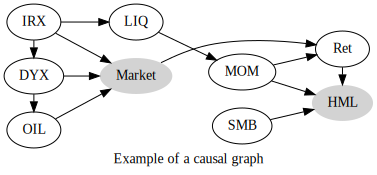

In [49]:
import graphviz as gr

chain = gr.Digraph(
    'G',
    node_attr = {'shape': 'ellipse'}, 
    graph_attr = {
        'rankdir': 'LR',
        'label': 'Example of a causal graph'
    }
)

chain.edge('Market', 'Ret')
chain.edge('MOM', 'Ret')
chain.edge('MOM', 'HML')
chain.edge('SMB', 'HML')
chain.edge('Ret', 'HML')
chain.edge('OIL', 'Market')
chain.edge('IRX', 'Market')
chain.edge('DYX', 'Market')
chain.edge('DYX', 'OIL')
chain.edge('IRX', 'DYX')
chain.edge('IRX', 'LIQ')
chain.edge('LIQ', 'MOM')

chain.node(
    'HML', style = 'filled', 
    fillcolor = 'lightgray', 
    shape = 'ellipse', 
    penwidth = '0'
)
chain.node(
    'Market', style = 'filled', 
    fillcolor = 'lightgray', 
    shape = 'ellipse', 
    penwidth = '0'
)

with chain.subgraph() as s:
    s.attr(rank = 'same') 
    s.node('Ret')
    s.node('HML')
with chain.subgraph() as s:
    s.attr(rank = 'same') 
    s.node('OIL')
    s.node('IRX')
    s.node('DYX')

chain